In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
path = untar_data(URLs.IMAGEWOOF); path.ls(), len(get_image_files(path/'train'))

((#3) [/home/jupyter/.fastai/data/imagewoof/models,/home/jupyter/.fastai/data/imagewoof/val,/home/jupyter/.fastai/data/imagewoof/train],
 12454)

In [3]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=lambda x: (path/'train').ls()[0].ls()[0],
                 )

In [4]:
bs, sz = 32, 64
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])
dbch.c = 3

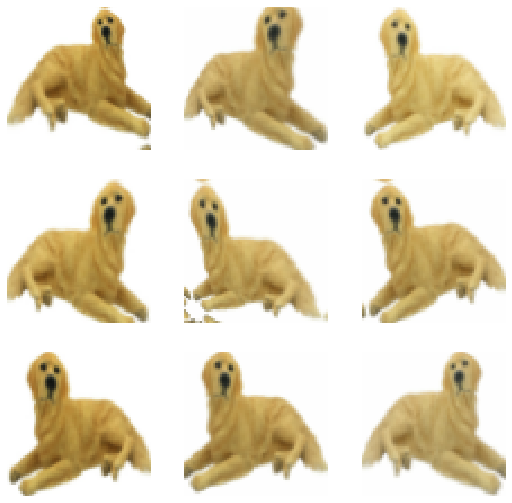

In [5]:
dbch.show_batch()

In [9]:
# How can I be sure this is working correctly?
pipe = Pipeline([PILImage.create, Resize(sz), ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe('styles/udnie.jpg').cuda())

In [10]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [11]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw):
        super().__init__()
        store_attr(self, 'm_feat,cnt_ls,stl_ls,cnt_lsw,stl_lsw')
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        
    def register_style(self, timg):
        # Features of style img, only needs to be computed once
        cnt_fs,stl_fs = self.get_fs(timg)
        self._stl_fs = stl_fs
#         self.style_fs = [o.repeat(bs,1,1,1) for o in stl_fs]

    # TODO: Doing this dynamically because of shape problem in validation
    def get_stl_fs(self, bs): return [o.repeat(bs,1,1,1) for o in self._stl_fs]
        
    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
#         stl_loss = self._stl_loss(pred_stl_fs)
#         cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        stl_loss2 = self._cnt_loss(pred,style_timg,pred_stl_fs,targ_stl_fs)
        return stl_loss2 #+ cnt_loss # Add a weight for each loss
        
    def _stl_loss(self, pred_fs):
        stl_fs = self.get_stl_fs(bs=pred_fs[0].shape[0])
        stl_loss = [base_loss(gram(pred_f),gram(style_f)*w**2*5e3)
                    for pred_f,style_f,w in zip(pred_fs,stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w**2*5e3 for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [12]:
vgg_m = vgg16_bn(True).features.cuda().eval()
for p in vgg_m.parameters(): p.requires_grad = False
requires_grad(vgg_m)

False

In [13]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
ls = [vgg_m[i] for i in blocks]

In [14]:
fst_loss = FSTLoss(vgg_m, cnt_ls =ls[2:5] , stl_ls= ls[1:4],
                          cnt_lsw=[5,15,2], stl_lsw=[15, 5, 2])
fst_loss.register_style(style_timg)

In [15]:
opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, **kwargs))

In [16]:
config = dict(blur=True, self_attention=True, y_range=(-3, 3), norm_type=NormType.Batch)
learn = unet_learner(dbch, partial(xresnet50, sa=True), loss_func=fst_loss, opt_func=opt_func, config=config)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

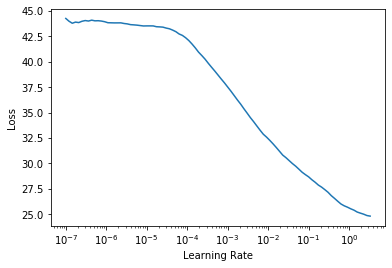

In [13]:
learn.lr_find()

In [14]:
learn.fit_flat_cos(1, 1e-2)

epoch,train_loss,valid_loss,time
0,4.112113,3.225836,03:01


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([48, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([48, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([48, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target 

In [19]:
res = learn.show_results(show=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


In [20]:
len(res)

TypeError: object of type 'NoneType' has no len()